#Staring Array Modelling

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module models the models the signal and noise in CCD and CMOS staring array sensors.  The code is originally based on the Matlab code described in *'High-level numerical simulations of noise in solid-state photosensors: review and tutorial'* by Mikhail Konnik and James Welsh, arXiv:1412.4031v1 [astro-ph.IM], available [here](http://arxiv.org/pdf/1412.4031.pdf)



## Concept

<font color="red">This is an early draft of the notebook, visit later for a more detailed update.</font>

The current version of the notebook demonstrates Konnik's 'Advanced' model.  For more information and detailed documentation see the [`rystare` documentation](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) or 
[the original Matlab code](https://bitbucket.org/aorta/highlevelsensorsim)

This model experiments with using HDF5 as a structured data store.  The motivation for this use and more information is available [here](https://github.com/NelisW/pyradi/blob/master/pyradi/hdf5-as-data-format.md)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pyradi.ryplot as ryplot
import re
import os.path
from scipy.optimize import curve_fit
import datetime

from matplotlib import cm as mcm
import matplotlib.mlab as mlab
import scipy.constants as const
import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
# import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
# import pyradi.rymodtran as rymodtran
import pyradi.rystare as rystare
import pyradi.ryutils as ryutils
# import xlsxwriter

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at 150 dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=150)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

Set up filenames for the run and open the HDF5 file.  

In [2]:
#set up the parameters for this run
outfilename = 'Output'
prefix = 'PA'

#open the file to create data structure and store the results, remove if exists
hdffilename = '{}{}.hdf5'.format(prefix, outfilename)
if os.path.isfile(hdffilename):
    os.remove(hdffilename)

The following code sets up the model data.  

Files remaining open, not closed after use, poses a problem in the notebook context where cells may be executed indivdually.  The limit the occurence of open files we open and close the file in each cell.

In [3]:
strh5 = ryfiles.open_HDF(hdffilename)

#sensor parameters
strh5['rystare/sensortype'] = 'CCD' # must be in capitals
strh5['rystare/fillfactor'] = 1.0 # Pixel Fill Factor for full-frame CCD photo sensors.
strh5['rystare/integrationtime'] = 0.01 # Exposure/Integration time, [sec].
strh5['rystare/externalquantumeff'] = 0.8  # external quantum efficiency, fraction not reflected.
strh5['rystare/quantumyield'] = 1. # number of electrons absorbed per one photon into material bulk
strh5['rystare/fullwellelectrons'] = 2e4 # full well of the pixel (how many electrons can be stored in one pixel), [e]
strh5['rystare/senseresetvref'] = 3.1 # Reference voltage to reset the sense node. [V] typically 3-10 V.

#sensor noise
strh5['rystare/sensenodegain'] = 5e-6 # Sense node gain, A_SN [V/e]

#source follower
strh5['rystare/sourcefollowergain'] = 1. # Source follower gain, [V/V], lower means amplify the noise.


# Analogue-to-Digital Converter (ADC)
strh5['rystare/ADC/num-bits'] = 12. # noise is more apparent on high Bits
strh5['rystare/ADC/offset'] = 0. # Offset of the ADC, in DN
strh5['rystare/ADC/nonlinearity/flag'] = False 

# Light Noise parameters
strh5['rystare/flag/photonshotnoise'] = True #photon shot noise.

# photo response non-uniformity noise (PRNU), or also called light Fixed Pattern Noise (light FPN)
strh5['rystare/detector/response/NU/flag'] = True
strh5['rystare/detector/response/NU/seed'] = 362436069
strh5['rystare/detector/response/NU/model'] = 'Janesick-Gaussian' 
strh5['rystare/detector/response/NU/spread'] = 0.01 # sigma [about 1\% for CCD and up to 5% for CMOS];

# Dark Current Noise parameters
strh5['rystare/flag/darkcurrent'] = True
strh5['rystare/operatingtemperature'] = 300. # operating temperature, [K]
strh5['rystare/darkfiguremerit'] = 1. # dark current figure of merit, [nA/cm2].  For very poor sensors, add DFM
#  Increasing the DFM more than 10 results to (with the same exposure time of 10^-6):
#  Hence the DFM increases the standard deviation and does not affect the mean value.

# dark current shot noise
strh5['rystare/flag/DarkCurrent-DShot'] = True

#dark current Fixed Pattern Noise 
strh5['rystare/darkresponse/NU/flag'] = True
strh5['rystare/darkresponse/NU/seed'] = 362436128
strh5['rystare/darkresponse/NU/limitnegative'] = True # only used with 'Janesick-Gaussian' 
strh5['rystare/darkresponse/NU/model'] = 'LogNormal' #suitable for long exposures
strh5['rystare/darkresponse/NU//spread'] = 0.4 #lognorm_sigma.

#dark current Offset Fixed Pattern Noise 
strh5['rystare/darkoffset/NU/flag'] = True
strh5['rystare/darkoffset/NU/model'] = 'Janesick-Gaussian'
strh5['rystare/darkoffset/NU/spread'] = 0.0005 # percentage of (V_REF - V_SN)

# Source Follower VV non-linearity
strh5['rystare/flag/VVnonlinearity'] = False

## Correlated Double Sampling (CDS)
strh5['rystare/sourcefollower/CDS-gain'] = 1. # CDS gain, [V/V], lower means amplify the noise.
strh5['rystare/sourcefollower/CDS-sampletosamplingtime'] = 1e-6 #CDS sample-to-sampling time [sec].

#source follower
strh5['rystare/sourcefollower/noise/flag'] = True
strh5['rystare/sourcefollower/flickerCornerHz'] = 1e6 #flicker noise corner frequency $f_c$ in [Hz], where power spectrum of white and flicker noise are equal [Hz].
strh5['rystare/sourcefollower/dataClockSpeed'] = 20e6 #MHz data rate clocking speed.
strh5['rystare/sourcefollower/whitenoisedensity'] = 15e-9 #thermal white noise [\f$V/Hz^{1/2}\f$, typically \f$15 nV/Hz^{1/2}\f$ ]
strh5['rystare/sourcefollower/deltaindmodulation'] = 1e-8 #[A] source follower current modulation induced by RTS [CMOS ONLY]
strh5['rystare/sourcefollower/freqsamplingdelta'] = 10000. #sampling spacing for the frequencies (e.g., sample every 10kHz);

#charge to voltage
strh5['rystare/flag/Venonlinearity'] = False

#sense node reset noise.
strh5['rystare/sensenode/resetnoise/flag'] = True
strh5['rystare/sensenode/resetfactor'] = 0.8 #[0,1]the compensation factor of the Sense Node Reset Noise: 

#For testing and measurements only:
strh5['rystare/flag/darkframe'] = False # True if no signal, only dark

strh5.flush()
strh5.close()

Download the image file from the GitHub directory. Normally you will prepare this file for your specific application.  The format for this file is described [here](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html#pyradi.rystare.create_HDF5_image).

In [4]:
pathtoimage = ryfiles.downloadFileUrl('https://github.com/NelisW/pyradi/raw/master/pyradi/data/image-Disk-256-256.hdf5',  
                              saveFilename='image-Stairslin-40-100-520.hdf5')

if pathtoimage is not None:
    imghd5 = ryfiles.open_HDF(pathtoimage)
else:
    imghd5 = None        

The input data has been set up, now execute the model. To test the model performance at the limits, uncomment one of the two `scaleInput` lines.  The first line provides a signal with small SNR whereas the second line provides a signal that saturates the well.

In [5]:
# scaleInput = 0.01 # for low SNR for Disk image
# scaleInput = 5 # saturates the well to full capacity for Disk image
scaleInput = 1 

if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    
    #images must be in photon rate irradiance units q/(m2.s)
    
    strh5['rystare/iradianceLux'] = scaleInput * imghd5['image/iradianceLux'].value
    strh5['rystare/signal/photonRateIrradianceNoNoise'] = scaleInput * imghd5['image/PhotonRateIrradianceNoNoise'].value
    strh5['rystare/signal/photonRateIrradiance'] = scaleInput * imghd5['image/PhotonRateIrradiance'].value
    strh5['rystare/pixelPitch'] = imghd5['image/pixelPitch'].value
    strh5['rystare/imageName'] = imghd5['image/imageName'].value
    strh5['rystare/imageFilename'] = imghd5['image/imageFilename'].value
    strh5['rystare/imageSizePixels'] = imghd5['image/imageSizePixels'].value
    strh5['rystare/wavelength'] = imghd5['image/wavelength'].value
    strh5['rystare/imageSizeRows'] = imghd5['image/imageSizeRows'].value
    strh5['rystare/imageSizeCols'] = imghd5['image/imageSizeCols'].value
    strh5['rystare/imageSizeDiagonal'] = imghd5['image/imageSizeDiagonal'].value

    #calculate the noise and final images
    strh5 = rystare.photosensor(strh5) # here the Photon-to-electron conversion occurred.
    strh5.flush()
    strh5.close()


Print some statistics of the sensor, noise and image

In [6]:
if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    print('Image file name           : {}'.format(strh5['rystare/imageName'].value))
    print('Image name                : {}'.format(strh5['rystare/imageName'].value))
    print('Sensor type               : {} '.format(strh5['rystare/sensortype'].value))
    print('Pixel pitch               : {} m'.format(strh5['rystare/pixelPitch'].value))
    print('Image size diagonal       : {} m'.format(strh5['rystare/imageSizeDiagonal'].value))
    print('Image size pixels         : {} '.format(strh5['rystare/imageSizePixels'].value))
    print('Fill factor               : {}'.format(strh5['rystare/fillfactor'].value))
    print('Full well electrons       : {} e'.format(strh5['rystare/fullwellelectrons'].value))
    print('Integration time          : {} s'.format(strh5['rystare/integrationtime'].value))
    print('Wavelength                : {} m'.format(strh5['rystare/wavelength'].value))
    print('Operating temperature     : {} K'.format(strh5['rystare/operatingtemperature'].value))
    print('Max FPA iradiance (lux)   : {}'.format(np.max(strh5['rystare/iradianceLux'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('PhotonRateIrradianceNoNoise',np.mean(strh5['rystare/signal/photonRateIrradianceNoNoise'].value), np.var(strh5['rystare/signal/photonRateIrradianceNoNoise'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalPhotonRateIrradiance',np.mean(strh5['rystare/signal/photonRateIrradiance'].value), np.var(strh5['rystare/signal/photonRateIrradiance'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('signalLight',np.mean(strh5['rystare/signal/light'].value), np.var(strh5['rystare/signal/light'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('signalDark',np.mean(strh5['rystare/signal/dark'].value), np.var(strh5['rystare/signal/dark'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('source_follower_noise',np.mean(strh5['rystare/sourcefollower/source_follower_noise'].value), np.var(strh5['rystare/sourcefollower/source_follower_noise'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalPhotons',np.mean(strh5['rystare/signal/photons'].value), np.var(strh5['rystare/signal/photons'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalElectrons',np.mean(strh5['rystare/signal/electrons'].value), np.var(strh5['rystare/signal/electrons'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalVoltage',np.mean(strh5['rystare/signal/voltage'].value), np.var(strh5['rystare/signal/voltage'].value)))
    print('{:26}: mean={:.5e}, var={:.5e}'.format('SignalDN',np.mean(strh5['rystare/signal/DN'].value), np.var(strh5['rystare/signal/DN'].value)))
    print('')
    print('ADC                       : gain={} bits={} offset={}'.format(strh5['rystare/ADC/gain'].value,strh5['rystare/ADC/num-bits'].value,strh5['rystare/ADC/offset'].value ))
    print('Dark current electrons    : {}'.format(strh5['rystare/darkcurrentelectrons'].value))
    print('Dark current figure-merit : {}'.format(strh5['rystare/darkfiguremerit'].value))
    print('Quantum external efficienc: {}'.format(strh5['rystare/externalquantumeff'].value))
    print('Quantum yield             : {}'.format(strh5['rystare/quantumyield'].value))
    print('Sense node gain           : {}'.format(strh5['rystare/sensenodegain'].value))
    print('Sense reset Vref          : {}'.format(strh5['rystare/senseresetvref'].value))
    print('Source follower gain      : {}'.format(strh5['rystare/sourcefollowergain'].value))
    print('k1 constant               : {}'.format(strh5['rystare/constants/k1'].value))
    if strh5['rystare/darkoffset/NU/flag'].value:
        print('Dark offset model         : {}'.format(strh5['rystare/darkoffset/NU/model'].value))
        print('Dark offset spread        : {}'.format(strh5['rystare/darkoffset/NU/spread'].value))
    print('Dark response model       : {}'.format(strh5['rystare/darkresponse/NU/model'].value))
    print('Dark response seed        : {}'.format(strh5['rystare/darkresponse/NU/seed'].value))
    print('Dark response spread      : {}'.format(strh5['rystare/darkresponse/NU/spread'].value))
    print('Dark response limit       : {}'.format(strh5['rystare/darkresponse/NU/limitnegative'].value))
    if strh5['rystare/detector/response/NU/flag'].value:
        print('Detector response mode    : {}'.format(strh5['rystare/detector/response/NU/model'].value))
        print('Detector response seed    : {}'.format(strh5['rystare/detector/response/NU/seed'].value))
        print('Detector response spread  : {}'.format(strh5['rystare/detector/response/NU/spread'].value))
    print('Material Eg 0 K            : {} eV'.format(strh5['rystare/material/Eg-eV-0'].value))
    print('Material Eg                : {} eV'.format(strh5['rystare/material/Eg-eV'].value))
    print('Material alpha             : {} '.format(strh5['rystare/material/alpha'].value))
    print('Material beta              : {} '.format(strh5['rystare/material/beta'].value))
    print('Sense node reset factor    : {} '.format(strh5['rystare/sensenode/resetfactor'].value))
    print('Sense node reset kTC sigma : {} '.format(strh5['rystare/sensenode/ResetKTC-sigma'].value))
    print('Sense node capacitance     : {} fF'.format(1e15 * strh5['rystare/sensenode/capacitance'].value))
    print('Sense node singal full well: {} V'.format(strh5['rystare/sensenode/volt-fullwell'].value))
    print('Sense node signal minimum  : {} V'.format(strh5['rystare/sensenode/volt-min'].value))
    print('Sense node reset noise     : {} '.format(strh5['rystare/sensenode/resetnoise/flag'].value))
    print('CDS gain                   : {}'.format(strh5['rystare/sourcefollower/CDS-gain'].value))
    print('CDS sample-to-sampling time: {}'.format(strh5['rystare/sourcefollower/CDS-sampletosamplingtime'].value))
    print('Delta induced modulation   : {}'.format(strh5['rystare/sourcefollower/deltaindmodulation'].value))
    print('Frequency sampling delta   : {}'.format(strh5['rystare/sourcefollower/freqsamplingdelta'].value))
    print('White noise density        : {}'.format(strh5['rystare/sourcefollower/whitenoisedensity'].value))
    print('Data clock speed           : {}'.format(strh5['rystare/sourcefollower/dataClockSpeed'].value))
    print('Flicker corner             : {} Hz'.format(strh5['rystare/sourcefollower/flickerCornerHz'].value))
    print('Source follower sigma      : {} '.format(strh5['rystare/sourcefollower/sigma'].value))
  
    
    strh5.flush()
    strh5.close()


Image file name           : Stairslin-40-40
Image name                : Stairslin-40-40
Sensor type               : CCD 
Pixel pitch               : [  5.00000000e-06   5.00000000e-06] m
Image size diagonal       : 0.00264764045897 m
Image size pixels         : [100 520] 
Fill factor               : 1.0
Full well electrons       : 20000.0 e
Integration time          : 0.01 s
Wavelength                : 5.5e-07 m
Operating temperature     : 300.0 K
Max FPA iradiance (lux)   : 25.2269954681
PhotonRateIrradianceNoNoise: mean=3.39785e+16, var=1.20289e+33
SignalPhotonRateIrradiance: mean=3.39785e+16, var=1.20289e+33
signalLight               : mean=6.79490e+03, var=4.81114e+07
signalDark                : mean=4.08656e+01, var=1.25164e+03
source_follower_noise     : mean=1.17721e-02, var=3.68987e+01
SignalPhotons             : mean=8.49465e+03, var=7.51810e+07
SignalElectrons           : mean=6.82358e+03, var=4.77987e+07
SignalVoltage             : mean=3.06588e+00, var=1.19497e-03
SignalDN 

In [7]:
def plotResults(imghd5, hdffilename, arrayname, bins=50, plotscale=1.0, logscale=False):
    if imghd5 is not None and hdffilename is not None:
        #open the sensor data file
        strh5 = ryfiles.open_HDF(hdffilename)
        #get the prescribed array
        arr = strh5['{}'.format(arrayname)].value 
        maxarr = np.max(arr)
        arr = strh5['{}'.format(arrayname)].value * plotscale
        arr = np.where(arr > maxarr, maxarr,arr) / plotscale
        if logscale:
            arr = np.log10(arr + 0.5)
            ptitle = "log('{}'+0.5)".format(arrayname.replace('rystare/',''))
        else:
            ptitle = "'{}'".format(arrayname.replace('rystare/',''))
        
        his, bin = np.histogram(arr,bins=bins)
        
        if np.min(arr) != np.max(arr):
            arrshift = arr - np.min(arr)
            arrshift = 255 * arrshift/np.max(arrshift)
            p = ryplot.Plotter(1,2,1,figsize=(8, 4))
#             p.showImage(1, arr, ptitle=ptitle, cmap=ryplot.cubehelixcmap(), cbarshow=True);
            p.showImage(1, arr, ptitle=ptitle, cmap=mcm.jet, cbarshow=True);
            p.showImage(2, arrshift, ptitle=ptitle, cmap=mcm.gray, cbarshow=False);
        if not logscale:
            r = ryplot.Plotter(2,1,1,figsize=(7, 2))
            r.plot(1, (bin[1:]+bin[:-1])/2, his, '{}, {} bins'.format(arrayname.replace('rystare/',''), bins), 'Magnitude','Counts / bin')

        strh5.flush()
        strh5.close()

The graph in the rest of the document shows signals at the stations marked in the signal flow diagram shown below.

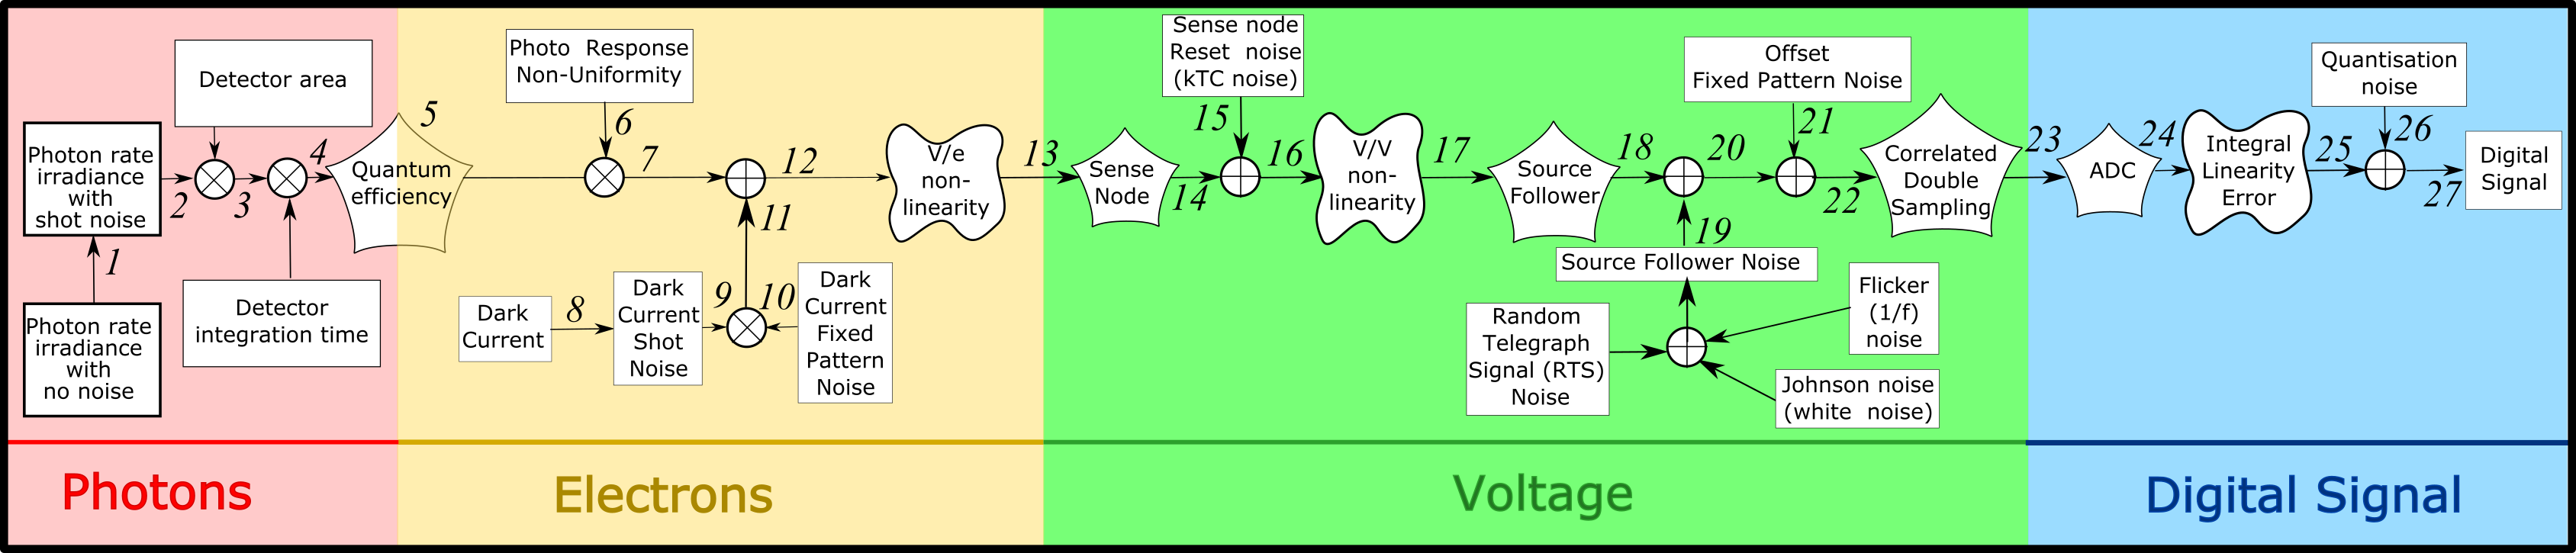

In [8]:
display(Image(filename='images/camerascheme_horiz-labelled.png', width=1000))

The externally created signal in photon rate irradiance [q/(m2.s)] (location 1 in the diagram).   This plot shows the image without photon noise.

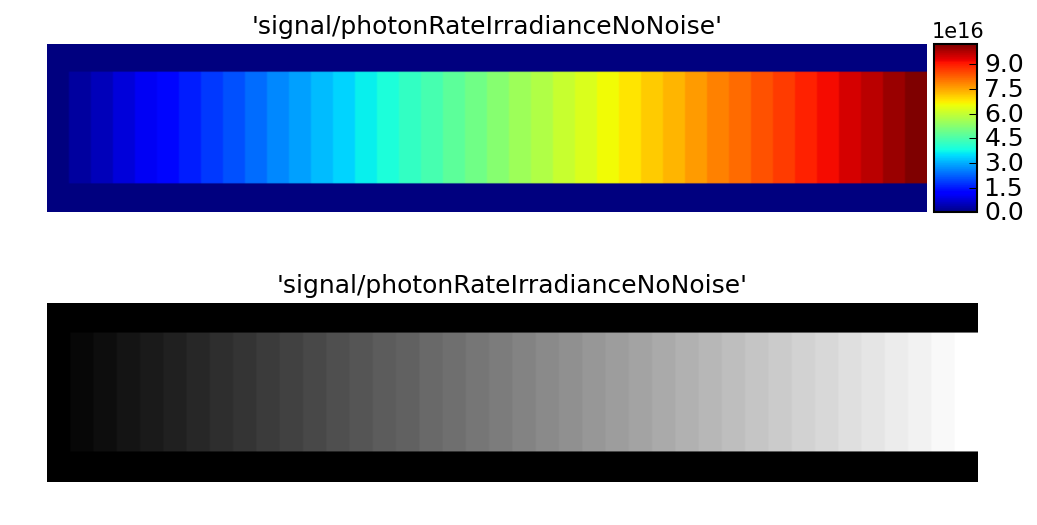

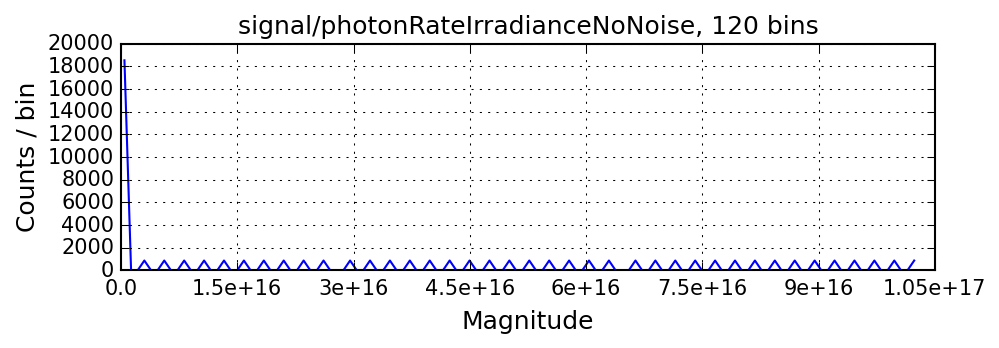

In [9]:
plotResults(imghd5, hdffilename, 'rystare/signal/photonRateIrradianceNoNoise', bins=120) 

The externally created signal in photon rate irradiance [q/(m2.s)] (location 2 in the diagram).   This plot shows the image with photon noise.

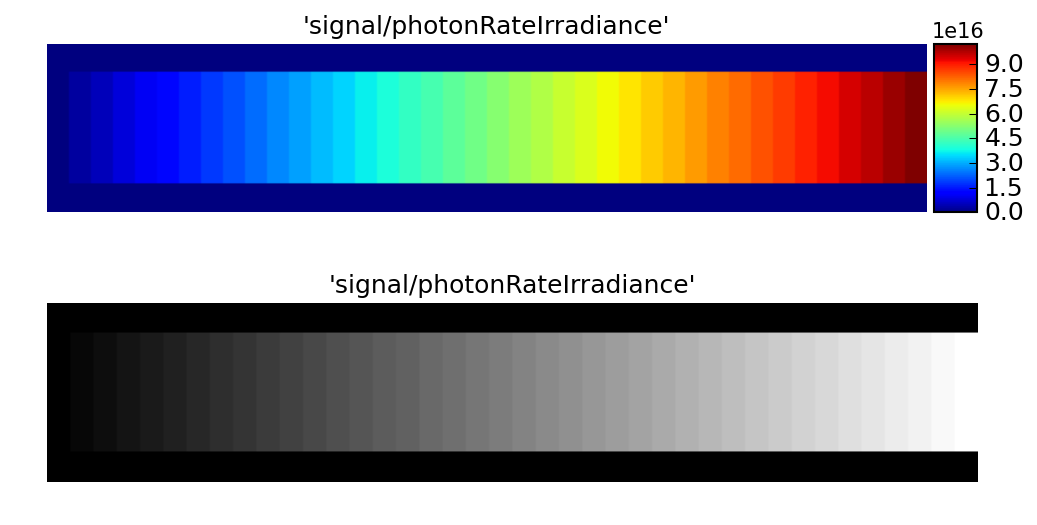

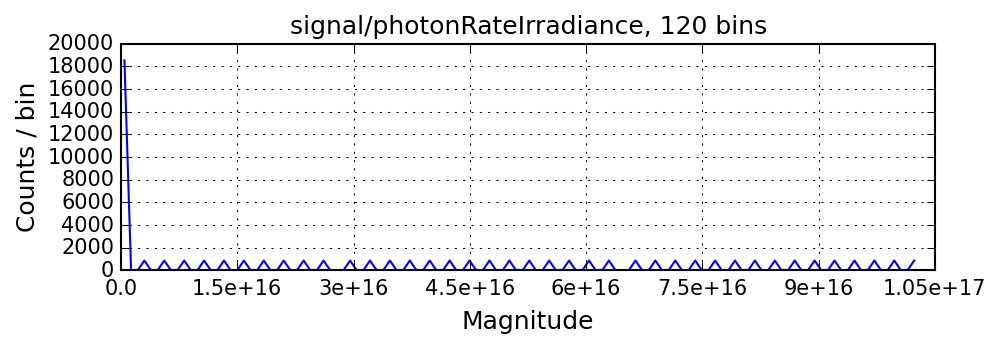

In [10]:
plotResults(imghd5, hdffilename, 'rystare/signal/photonRateIrradiance', bins=120) 

The photon rate irradiance multiplied with the detector area yields the photon rate in one detector (location 3 in the diagram):

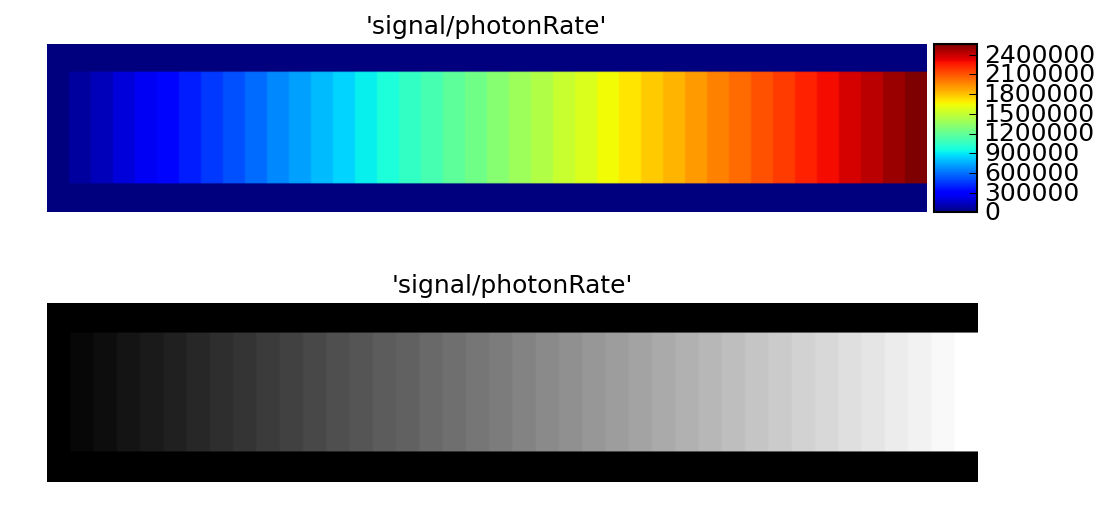

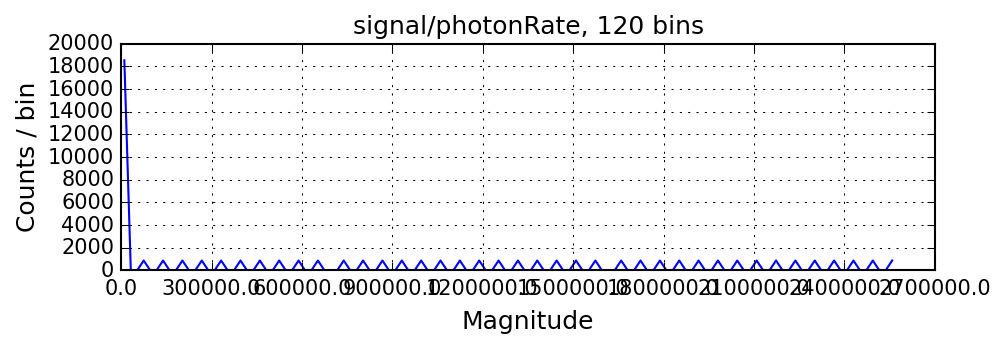

In [11]:
plotResults(imghd5, hdffilename, 'rystare/signal/photonRate', bins=120) 

The photon rate multiplied with the integration time yields the maximum number of photons available for accumulation (location 4 in the diagram):

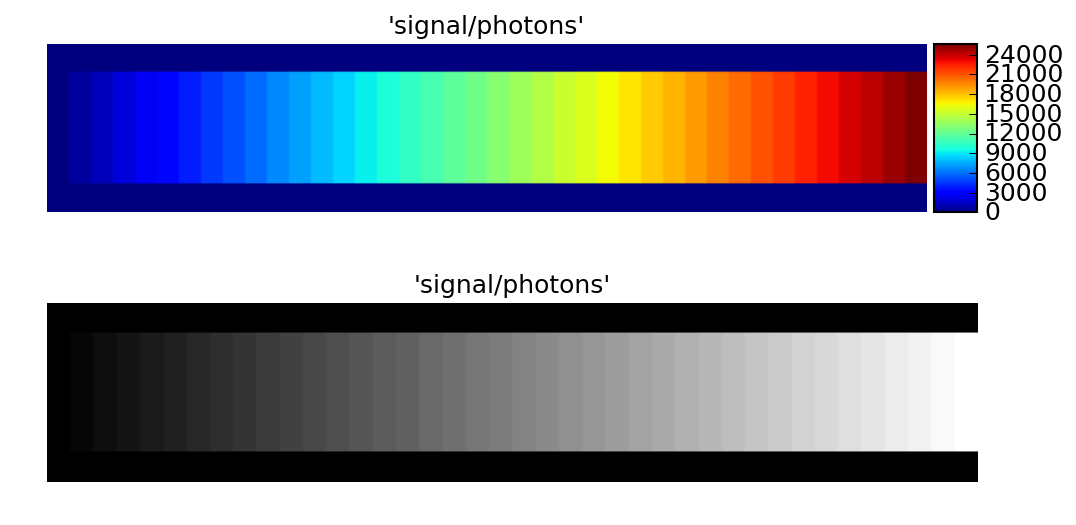

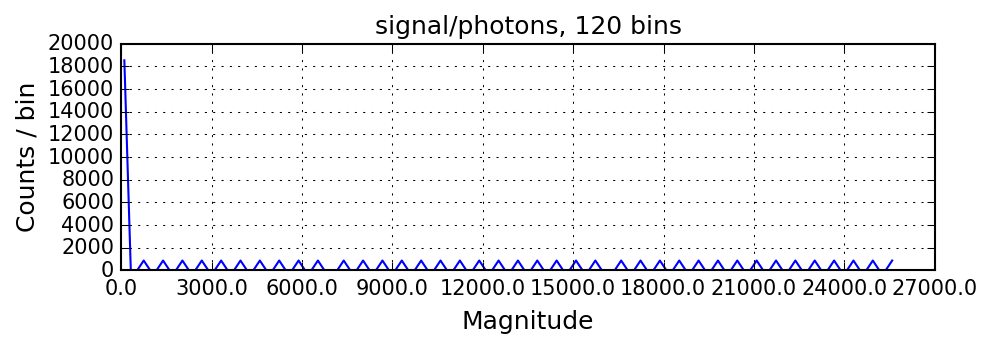

In [12]:
plotResults(imghd5, hdffilename, 'rystare/signal/photons', bins=120) 

Detector element quantum efficiency (location 5 in the diagram):

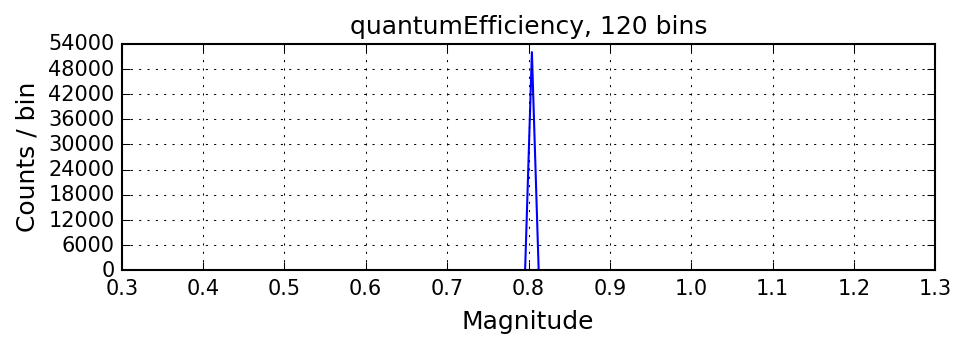

In [13]:
plotResults(imghd5, hdffilename, 'rystare/quantumEfficiency', bins=120) 

The focal plane's spatial nonuniformity is calculated next, as a Gaussian distribution around unity (location 6 in the diagram):

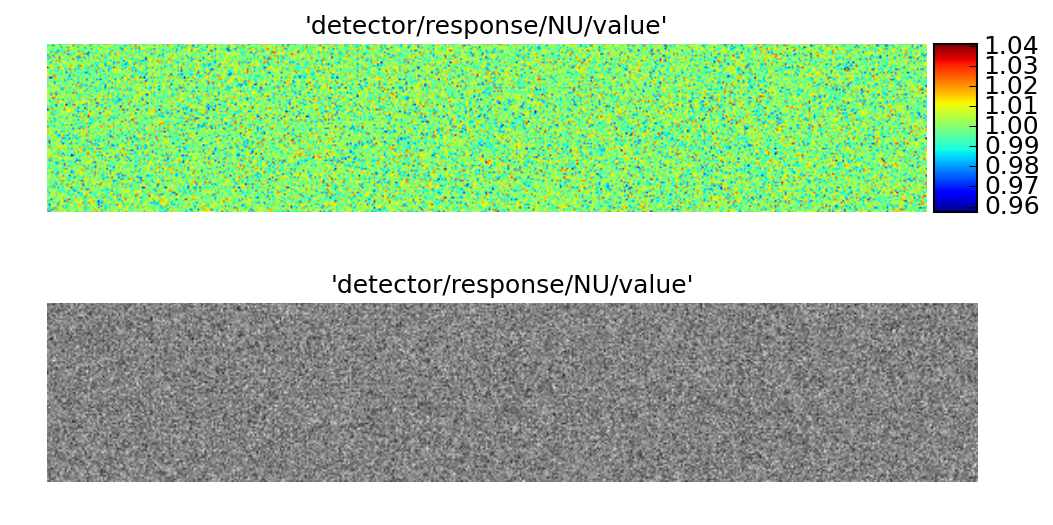

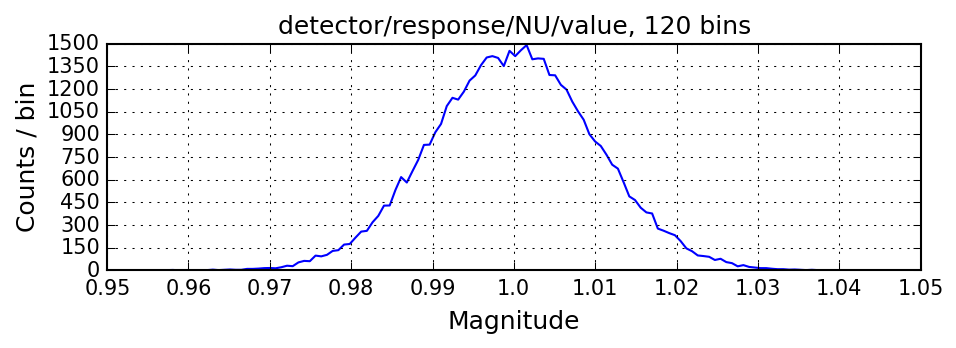

In [14]:
plotResults(imghd5, hdffilename, 'rystare/detector/response/NU/value', bins=120) 

The photon count multiplied with the nonuniformity yields the photon count actually recorded in the charge wells (location 7 in the diagram):

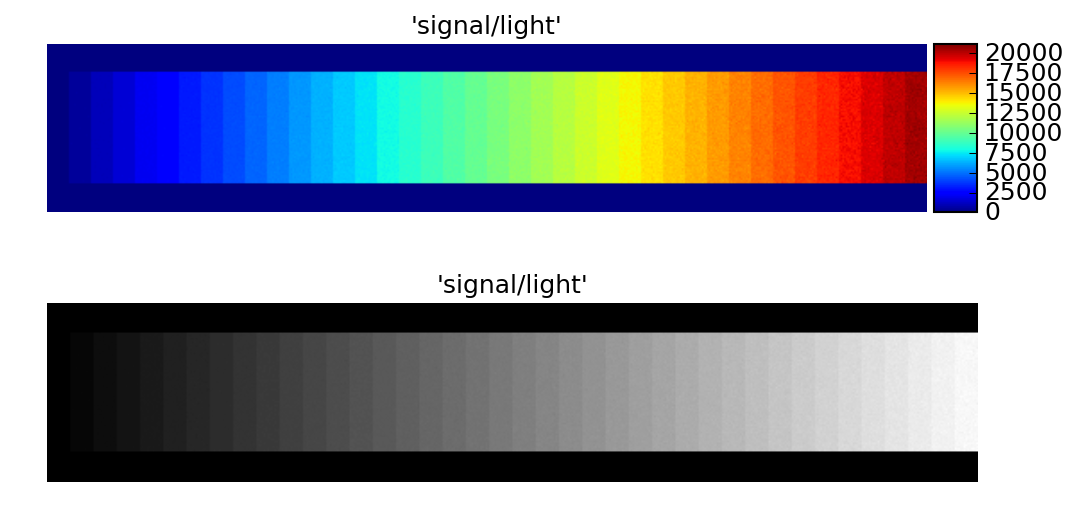

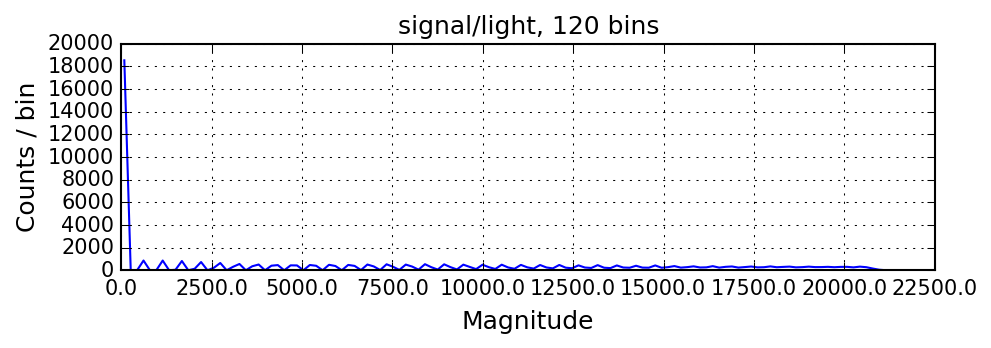

In [15]:
plotResults(imghd5, hdffilename, 'rystare/signal/light', bins=120) 

The focal plane nonuniformity for dark noise generation for the advanced model follows a lognormal distribution.  The relatively few high values are quite evident in these graphs (location 10 in the diagram):


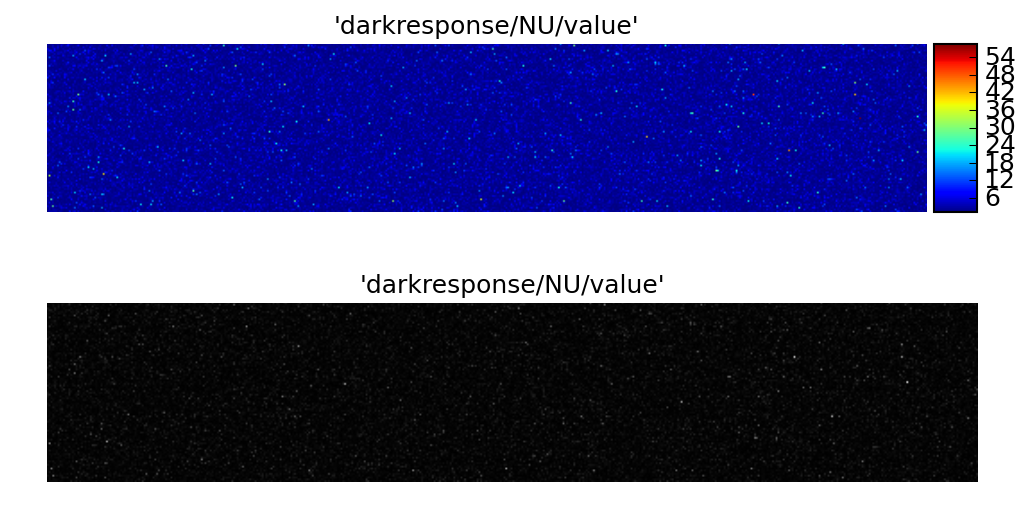

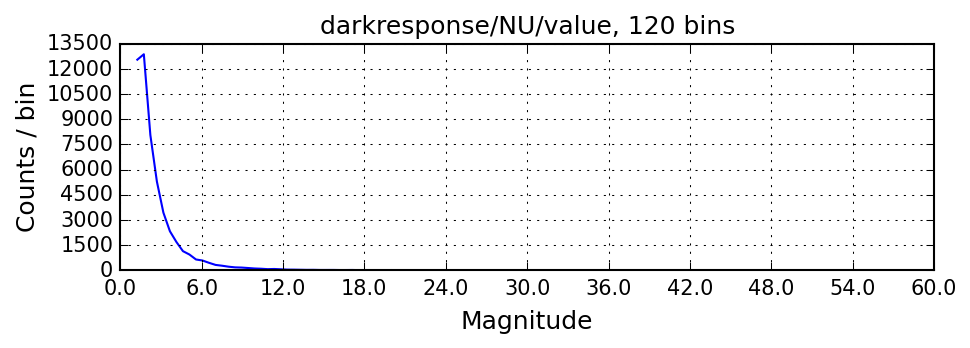

In [16]:
plotResults(imghd5, hdffilename, 'rystare/darkresponse/NU/value', bins=120) 


The dark noise signal is given by the dark noise nonuniformity multiplied by the mean dark current (location 9 in the diagram):


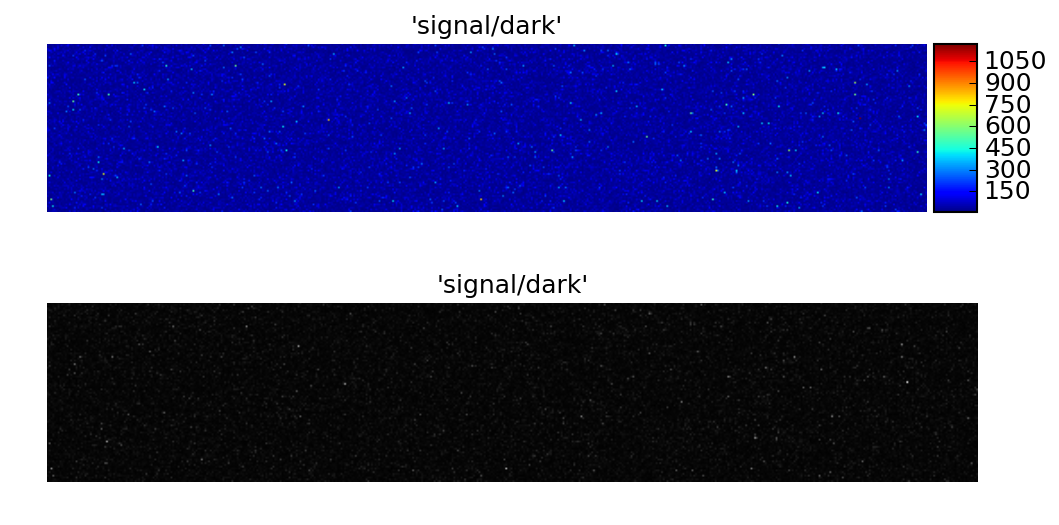

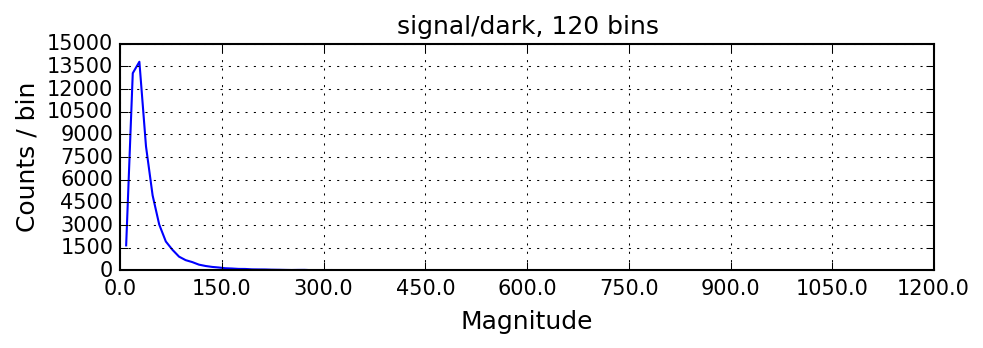

In [17]:
plotResults(imghd5, hdffilename, 'rystare/signal/dark', bins=120) 

The signal in electrons (location 12 in the diagram):

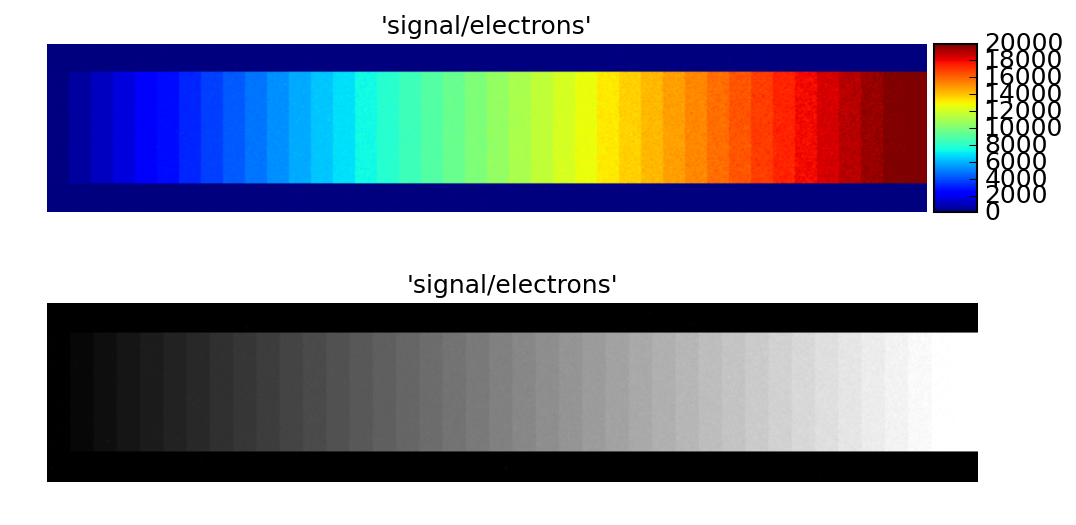

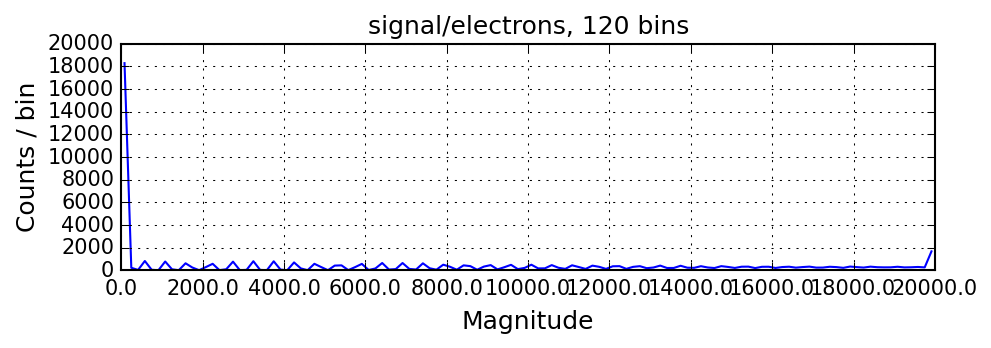

In [18]:
plotResults(imghd5, hdffilename, 'rystare/signal/electrons', bins=120) 

The reset noise variation over the array (location 15 in the diagram):

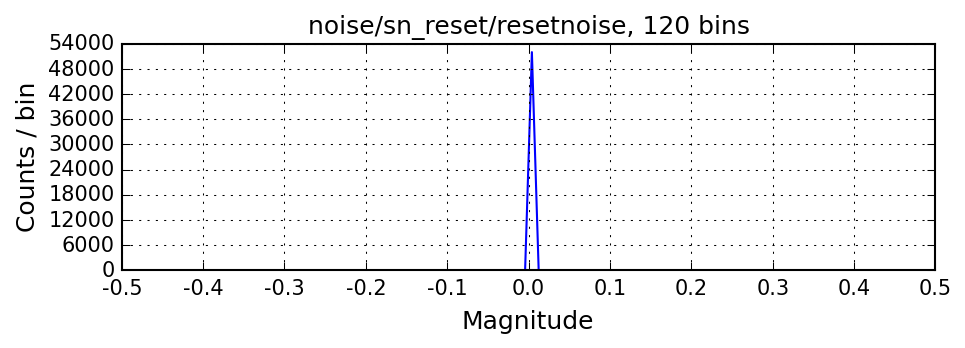

In [19]:
plotResults(imghd5, hdffilename, 'rystare/noise/sn_reset/resetnoise', bins=120) 

The source follower noise in electrons (location 19 in the diagram):

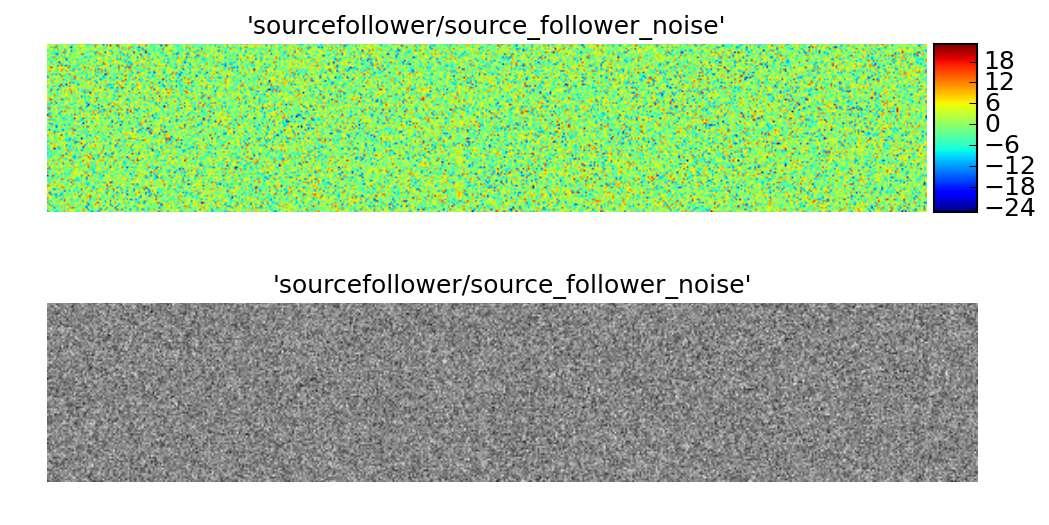

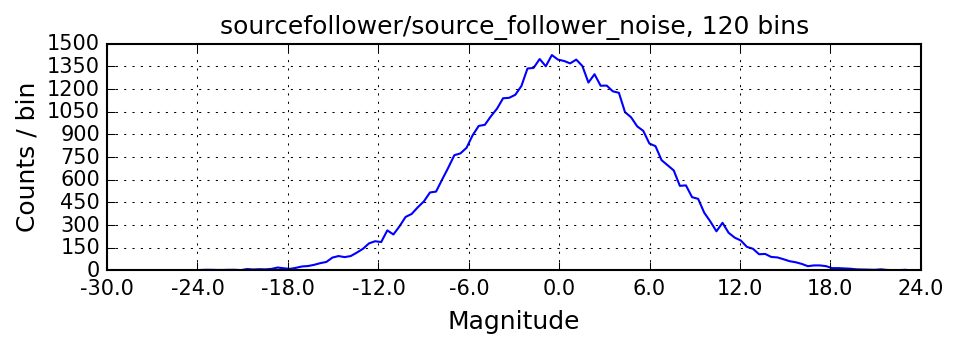

In [20]:
plotResults(imghd5, hdffilename, 'rystare/sourcefollower/source_follower_noise', bins=120) 

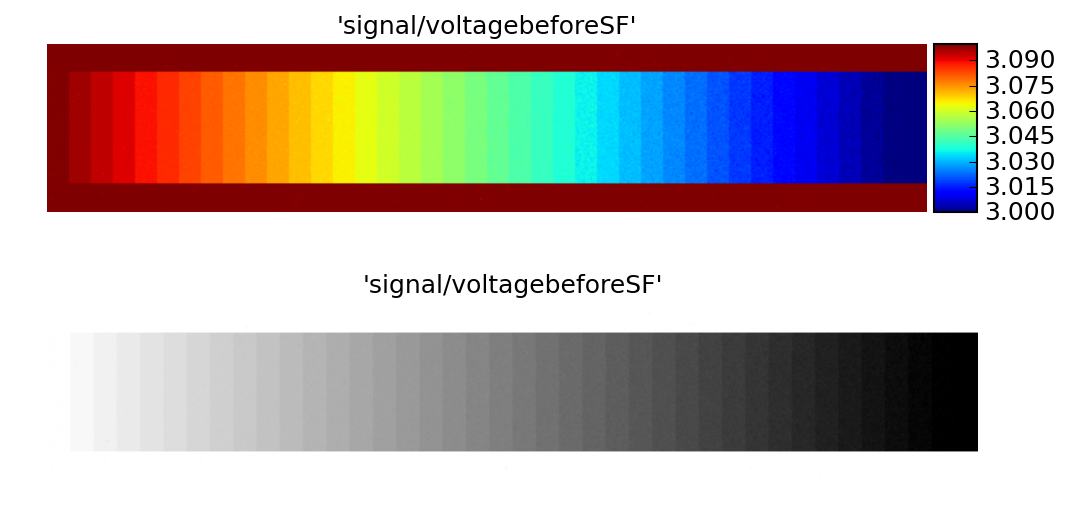

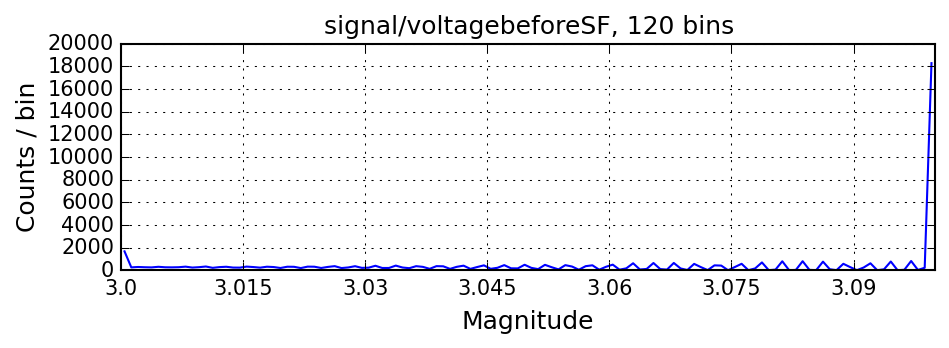

In [21]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltagebeforeSF', bins=120) 

The (inverted) signal converted to voltage on the FPA output (location 18 in the diagram):

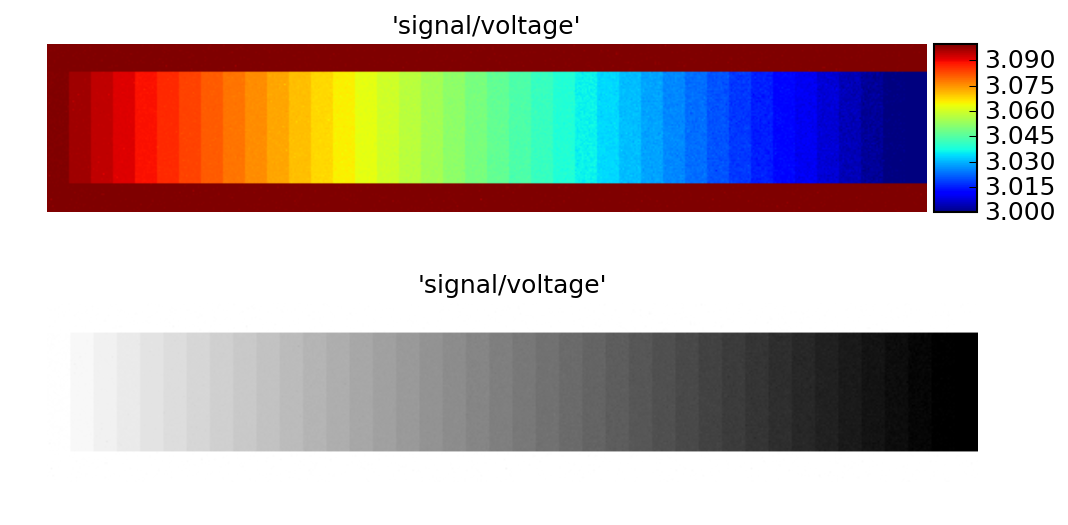

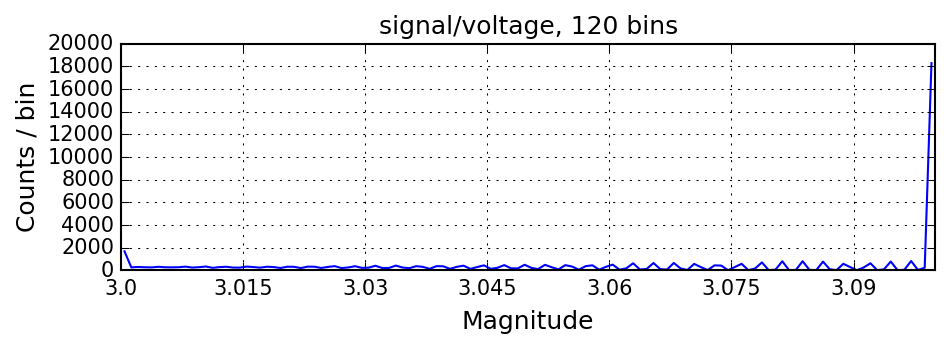

In [22]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltage', bins=120) 

The dark offset nonuniformity (location 21 in the diagram):

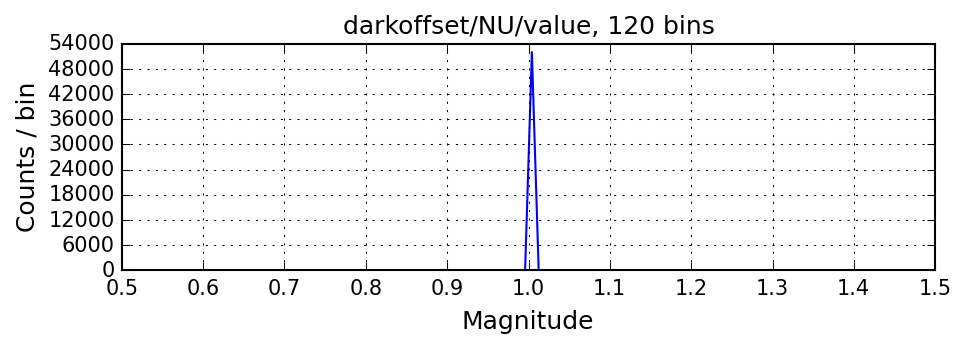

In [23]:
plotResults(imghd5, hdffilename, 'rystare/darkoffset/NU/value', bins=120) 

Signal converted to digital counts (location 25 in the diagram). This is the full scale dynamic range present in the image.  If the charge well is saturated, the value shown here should correspond with the full well capacity.

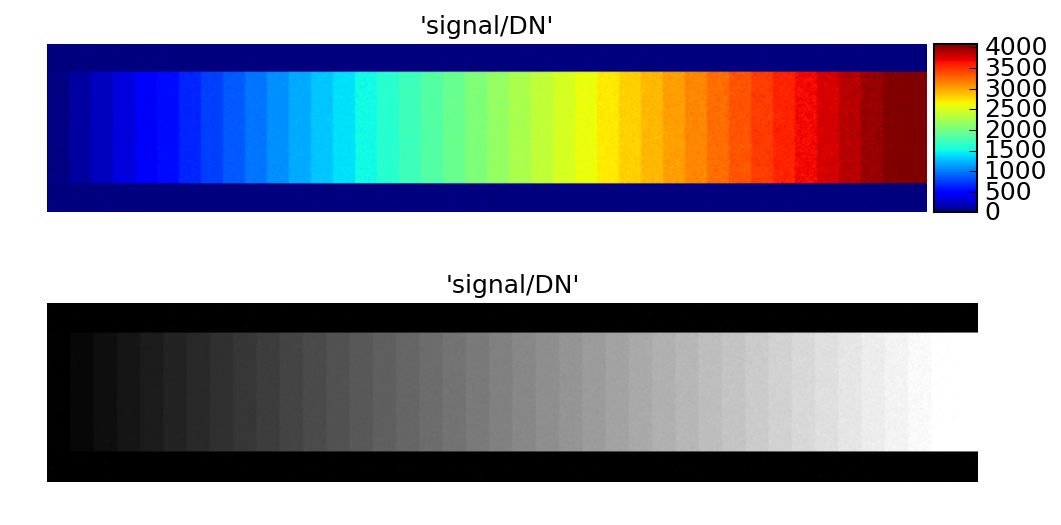

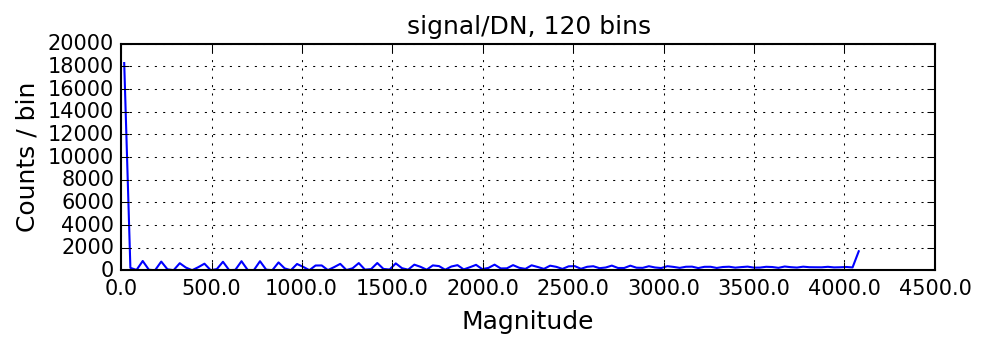

In [24]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', bins=120) 

Signal converted to digital counts  (location 25 in the diagram). This graph is intensity scaled 100 times larger than the previous image.  At this gain, the noise should be visible but higher signal levels will exceed the plot scale.

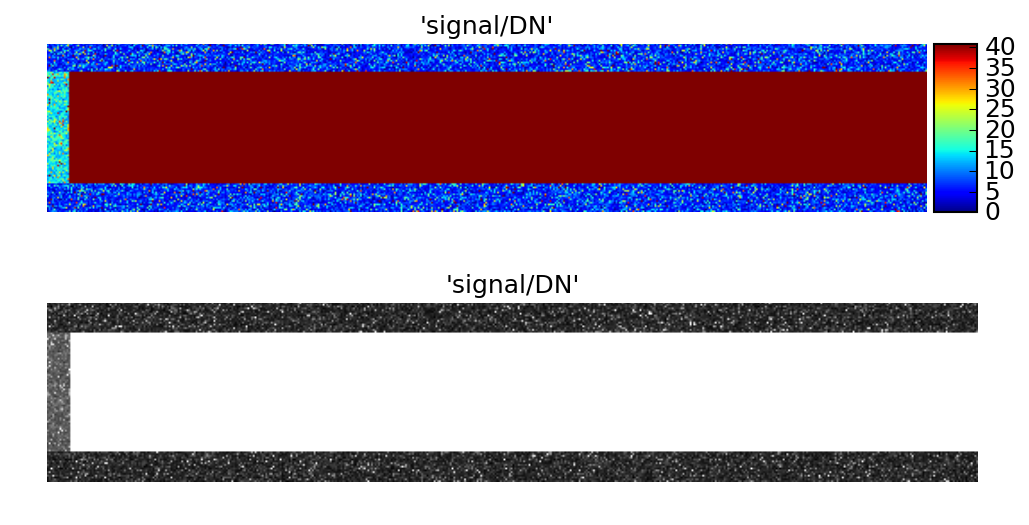

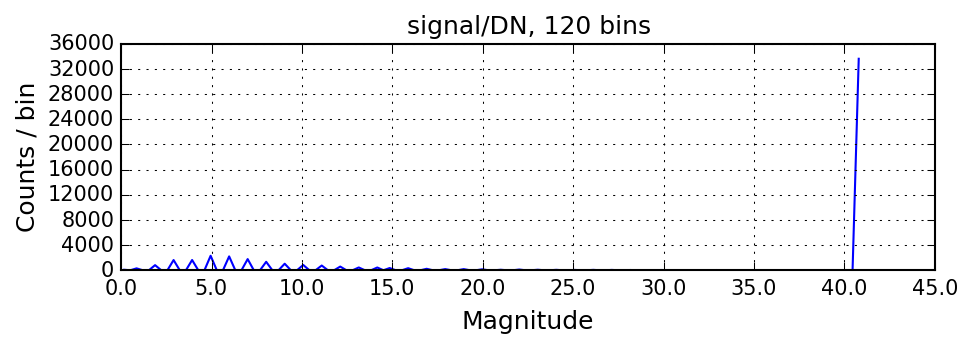

In [25]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', bins=120, plotscale=100) 

Signal converted to digital counts  (location 25 in the diagram). This graph shows the log-base10 values in the image. The image is offset by half a digital count to prevent log(0) errors.

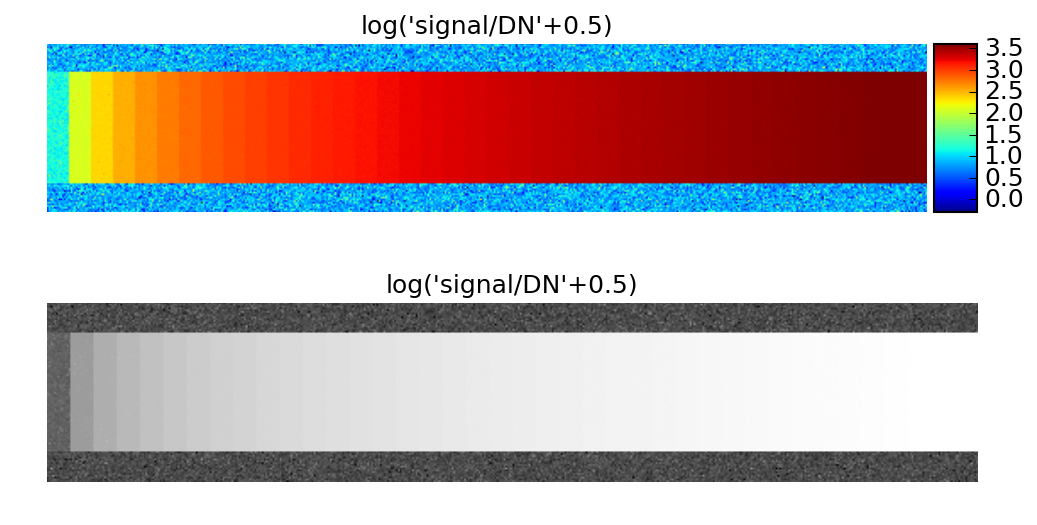

In [26]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', bins=120, plotscale=1, logscale=True) 

Next we will attempt to calculate the photon transfer function and signal to noise ratio for the various parts of the image.

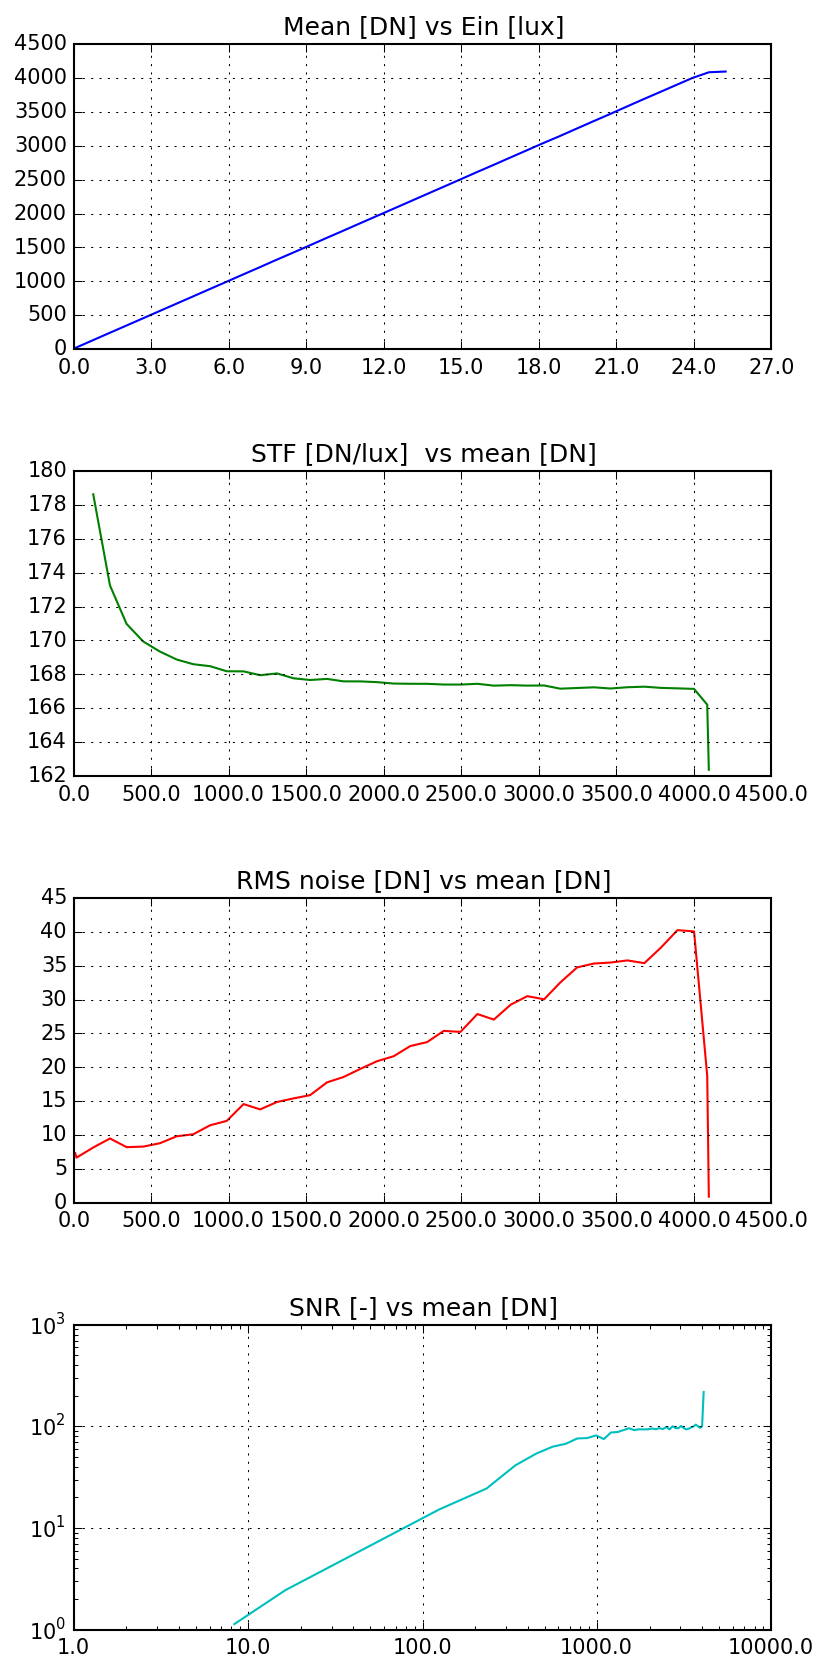

In [27]:
tplZones = collections.namedtuple('tplZones', ['ein', 'count','mean','var','std','snr','stf'], verbose=False)
lstZones = []
if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    #get the list of unique zones in the image
    arrnn = strh5['rystare/iradianceLux'].value
#     arrnn = strh5['rystare/PhotonRateIrradianceNoNoise'].value
    arr = strh5['rystare/signal/DN'].value
    uniqueZs, uCnts = np.unique(arrnn, return_counts=True)
#     print(uniqueZs, uCnts)
    for uniqueZ,ucnt in zip(uniqueZs,uCnts):
        zone = arr[arrnn==uniqueZ]
        mean = np.mean(zone)
        lstZones.append(tplZones(ein=uniqueZ, count=ucnt, mean=mean, 
                        var=np.var(zone-mean), std=np.std(zone-mean), 
                        snr=np.mean(zone)/np.std(zone-mean),
                        stf=np.mean(zone)/uniqueZ))
    strh5.flush()
    strh5.close()


# print(lstZones) 
#build numpy arrays of the results
ein = np.asarray([x.ein for x in lstZones])
mean = np.asarray([x.mean for x in lstZones])
var = np.asarray([x.var for x in lstZones])
std = np.asarray([x.std for x in lstZones])
snr = np.asarray([x.snr for x in lstZones])
stf = np.asarray([x.stf for x in lstZones])

p = ryplot.Plotter(1,4,1,figsize=(6,14));
p.plot(1,ein,mean,'Mean [DN] vs Ein [lux]');
p.plot(2,mean[2:],stf[2:],'STF [DN/lux]  vs mean [DN]');
p.plot(3,mean,std,'RMS noise [DN] vs mean [DN]');
p.logLog(4,mean[:-1],snr[:-1],'SNR [-] vs mean [DN]');

##Comments

1.  The small target image used here is relatively small and does not provide adequate statistics.  It serves as proof-of-concept in this analysis.

1. A more detailed discussion of the results will be done in due course.



## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [28]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.8 32bit [MSC v.1500 32 bit (Intel)]
IPython 3.0.0
OS Windows 7 6.1.7601 SP1
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
pyradi 0.1.58
Wed Jun 24 20:05:42 2015 South Africa Standard Time